<a href="https://colab.research.google.com/github/WilLO86/Video-Processing-and-Contour-Detection-Using-OpenCV/blob/main/Video_Processing_and_Contour_Detection_Using_OpenCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The main goal of this assigment will be to develop three computer vision applications: a video I/O application, a motion detection system with foreground mass and erosion, and a contour detection application.
To create the necessary media assets, I used two powerful tools from ChatGPT: SORA and DALL-E.
-SORA was utilized to generate a synthetic video clip, which served as the primary input for the video processing and motion detection parts of the project.
DALL-E was used to create a synthetic image containing distinct geometric shapes.


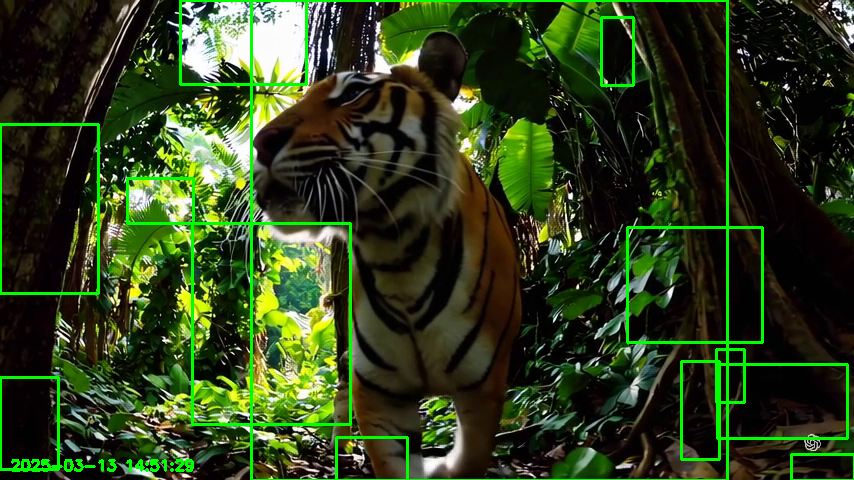

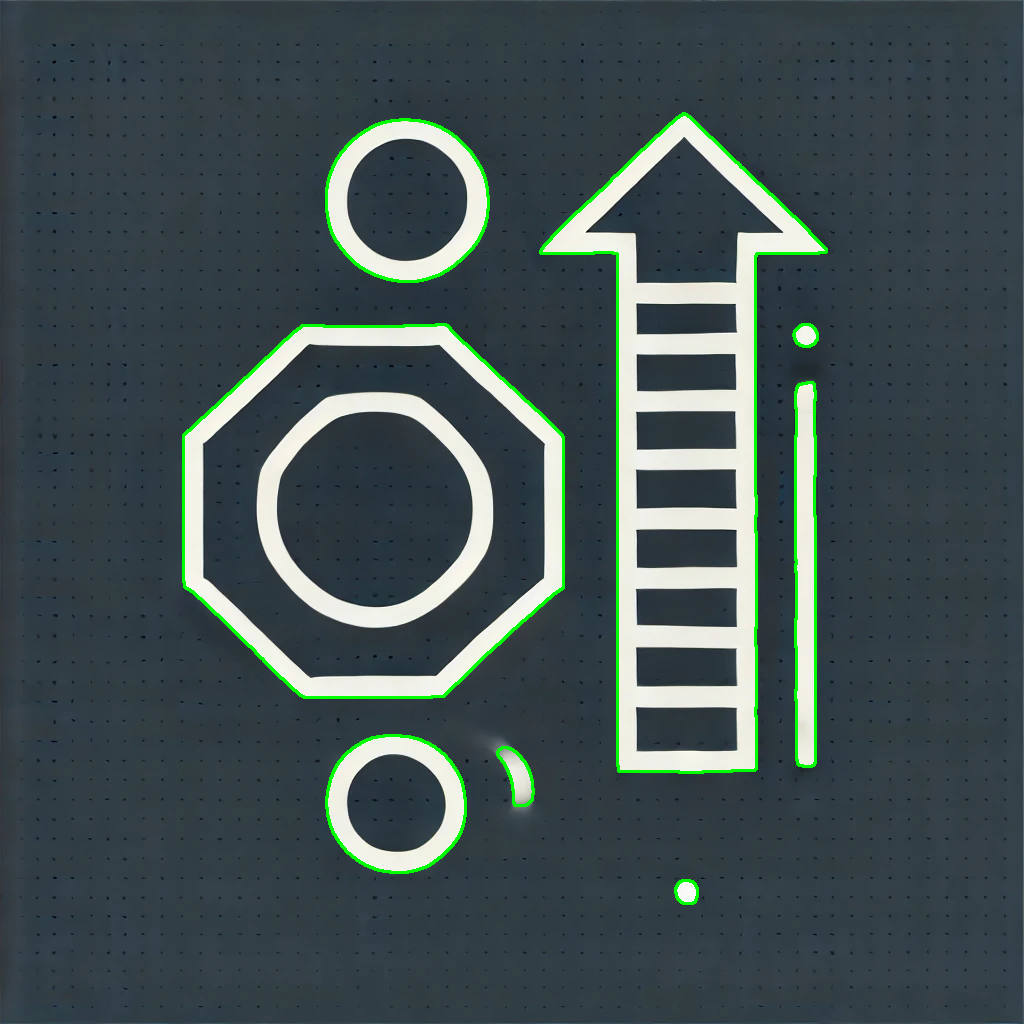

In [6]:
import cv2
import datetime
import time
import numpy as np
from google.colab.patches import cv2_imshow
from IPython.display import clear_output

# Define input and output video paths
input_video = '/content/SORA_Majestic Jungle Tiger.mp4'
output_video = 'output_video.mp4'

# Create a video capture object from the VideoCapture Class.
cap = cv2.VideoCapture(input_video)
if not cap.isOpened():
    print("Error opening video file")
    exit()

# Retrieve video properties for output settings
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Specify the codec (MP4)

# Create the VideoWriter object to write processed frames to a new video file.
out = cv2.VideoWriter(output_video, fourcc, fps, (frame_width, frame_height), isColor=True)


# ----------------------------
# Background Modeling Section
# ----------------------------

# Create a background model from the initial frames (e.g., first 30 frames)
bg_frames = []
num_bg_frames = 30  # You can adjust this number based on your video
count = 0

while count < num_bg_frames:
    ret, frame = cap.read()
    if not ret:
        break  # Stop if no frame is available
    # Convert the frame to grayscale for background modeling
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    bg_frames.append(gray.astype("float"))
    count += 1

if len(bg_frames) == 0:
    print("Not enough frames to build a background model.")
    cap.release()
    exit()

# Compute the background model as the average of the initial frames
background_model = np.mean(bg_frames, axis=0).astype("uint8")

# Reset the video capture to start processing from the beginning
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)





# ---------------------------------------------------------------------------------------
# Motion Detection Application with Foreground Mass and Erosion & Video Contour Detection
# ---------------------------------------------------------------------------------------

while True:
    ret, frame = cap.read()
    if not ret:
        break  # Exit the loop if no frame is read

    # Convert the current frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Compute the foreground mass by taking the absolute difference between the current frame and the background model
    diff = cv2.absdiff(background_model, gray)

    # Threshold the difference to obtain a binary foreground mask
    # Pixels with intensity differences greater than 25 become white (foreground), the rest become black (background)
    _, fg_mask = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)

    # Apply erosion to the foreground mask to remove small, isolated noise pixels.
    # Erosion is a morphological operation that shrinks the foreground areas.
    kernel = None  # Using the default 3x3 kernel
    eroded_mask = cv2.erode(fg_mask, kernel, iterations=2)

    # Display intermediate visualizations:
    clear_output(wait=True)
    cv2_imshow(fg_mask)
    time.sleep(0.5)
    clear_output(wait=True)
    cv2_imshow(eroded_mask)
    time.sleep(0.5)

    # Find contours on the eroded mask to detect motion regions
    contours, _ = cv2.findContours(eroded_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Annotate the frame by drawing bounding boxes around regions with significant motion
    for contour in contours:
        if cv2.contourArea(contour) < 500:  # Filter out small areas (noise)
            continue
        (x, y, w, h) = cv2.boundingRect(contour)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Optionally, overlay a timestamp on the frame
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    cv2.putText(frame, timestamp, (10, frame_height - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Write the annotated frame to the output video file
    out.write(frame)

    # For quick visualization in Colab without blocking, clear output and display the frame.
    clear_output(wait=True)
    cv2_imshow(frame)
    time.sleep(1/fps)

# Release the video capture and writer objects
cap.release()
out.release()





# -----------------------------------
# Contour Detection on a Static Image
# -----------------------------------

# Define the input image path
image_path = '/content/DALL·E_A minimalistic digital illustration with three simple geometric shapes.png'

# Load the image from file
image = cv2.imread(image_path)
if image is None:
    print("Error loading image")
    exit()

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply a binary threshold to create a binary image
# Pixels with intensity greater than 127 become white, otherwise black.
_, thresh_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

# Use cv2.findContours to detect contours in the binary image
# cv2.RETR_EXTERNAL retrieves only the external contours.
# cv2.CHAIN_APPROX_SIMPLE compresses horizontal, vertical, and diagonal segments.
contours, hierarchy = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Use cv2.drawContours to overlay the detected contours on the original image.
# -1 means draw all contours.
cv2.drawContours(image, contours, -1, (0, 255, 0), 2)

# Display the resulting image with contours drawn.
cv2_imshow(image)

Conclusions:
The video processing and motion detection modules performed effectively, with the system successfully detecting motion through background subtraction and noise reduction using erosion. The contour detection application accurately identified and drew bounding contours around the shapes in the synthetic image and video frames.
